<a href="https://colab.research.google.com/github/NSJayaweera/NCD-Risk_Prediction/blob/Diabetes/DiabetesRiskPrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================
# 1. SETUP AND DATA LOADING
# ============================================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, roc_auc_score, confusion_matrix,
                           classification_report, roc_curve, auc)
import warnings
warnings.filterwarnings('ignore')

# Import all required models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB


from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier, StackingClassifier


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import pandas as pd
file_path = '/content/drive/MyDrive/YourFolder/balanced_diabetes_data.csv'
df = pd.read_csv(file_path)

In [4]:


print("="*60)
print("1. DATA LOADING COMPLETE")
print("="*60)
print(f"Dataset shape: {df.shape}")
print("\nFirst 5 rows:")
print(df.head())

1. DATA LOADING COMPLETE
Dataset shape: (1761, 14)

First 5 rows:
   user_id        date     weight      height  blood_glucose  \
0      595  2022-10-13  85.563099  150.000000     173.937235   
1      275  2021-10-28  55.277370  182.130977      96.510162   
2      854  2023-07-24  87.835248  179.191542     148.821657   
3      157  2021-06-20  97.986618  163.118496     124.992145   
4      663  2022-12-26  69.508701  150.000000     163.889129   

   physical_activity  diet  medication_adherence  stress_level  sleep_hours  \
0          55.184665     1                     1             2     9.268495   
1          11.674518     0                     0             2    10.361847   
2           7.856864     1                     0             2     5.025379   
3           5.251467     0                     1             0     6.398124   
4          37.466971     1                     0             1     6.932074   

   hydration_level   bmi  risk_score risk_level  
0                1  38.0

In [5]:

# ============================================
# 2. DATA CLEANING
# ============================================
print("\n" + "="*60)
print("2. DATA CLEANING")
print("="*60)

# Remove duplicates
df = df.drop_duplicates()

# Clean unrealistic values
df = df[(df['weight'] > 30) & (df['weight'] < 200)]
df = df[(df['height'] > 100) & (df['height'] < 250)]
df = df[(df['bmi'] > 10) & (df['bmi'] < 60)]
df = df[(df['blood_glucose'] >= 70) & (df['blood_glucose'] <= 300)]
df = df[(df['sleep_hours'] >= 0) & (df['sleep_hours'] <= 24)]

print(f"Shape after cleaning: {df.shape}")

# Check correlation between features
print("\n" + "-"*40)
print("CORRELATION ANALYSIS")
print("-"*40)
# Check correlation between weight, height, and BMI
correlation_check = df[['weight', 'height', 'bmi']].corr()
print("Correlation between weight, height, and BMI:")
print(correlation_check)


2. DATA CLEANING
Shape after cleaning: (713, 14)

----------------------------------------
CORRELATION ANALYSIS
----------------------------------------
Correlation between weight, height, and BMI:
          weight    height       bmi
weight  1.000000 -0.048747  0.875669
height -0.048747  1.000000 -0.512119
bmi     0.875669 -0.512119  1.000000



3. EXPLORATORY DATA ANALYSIS


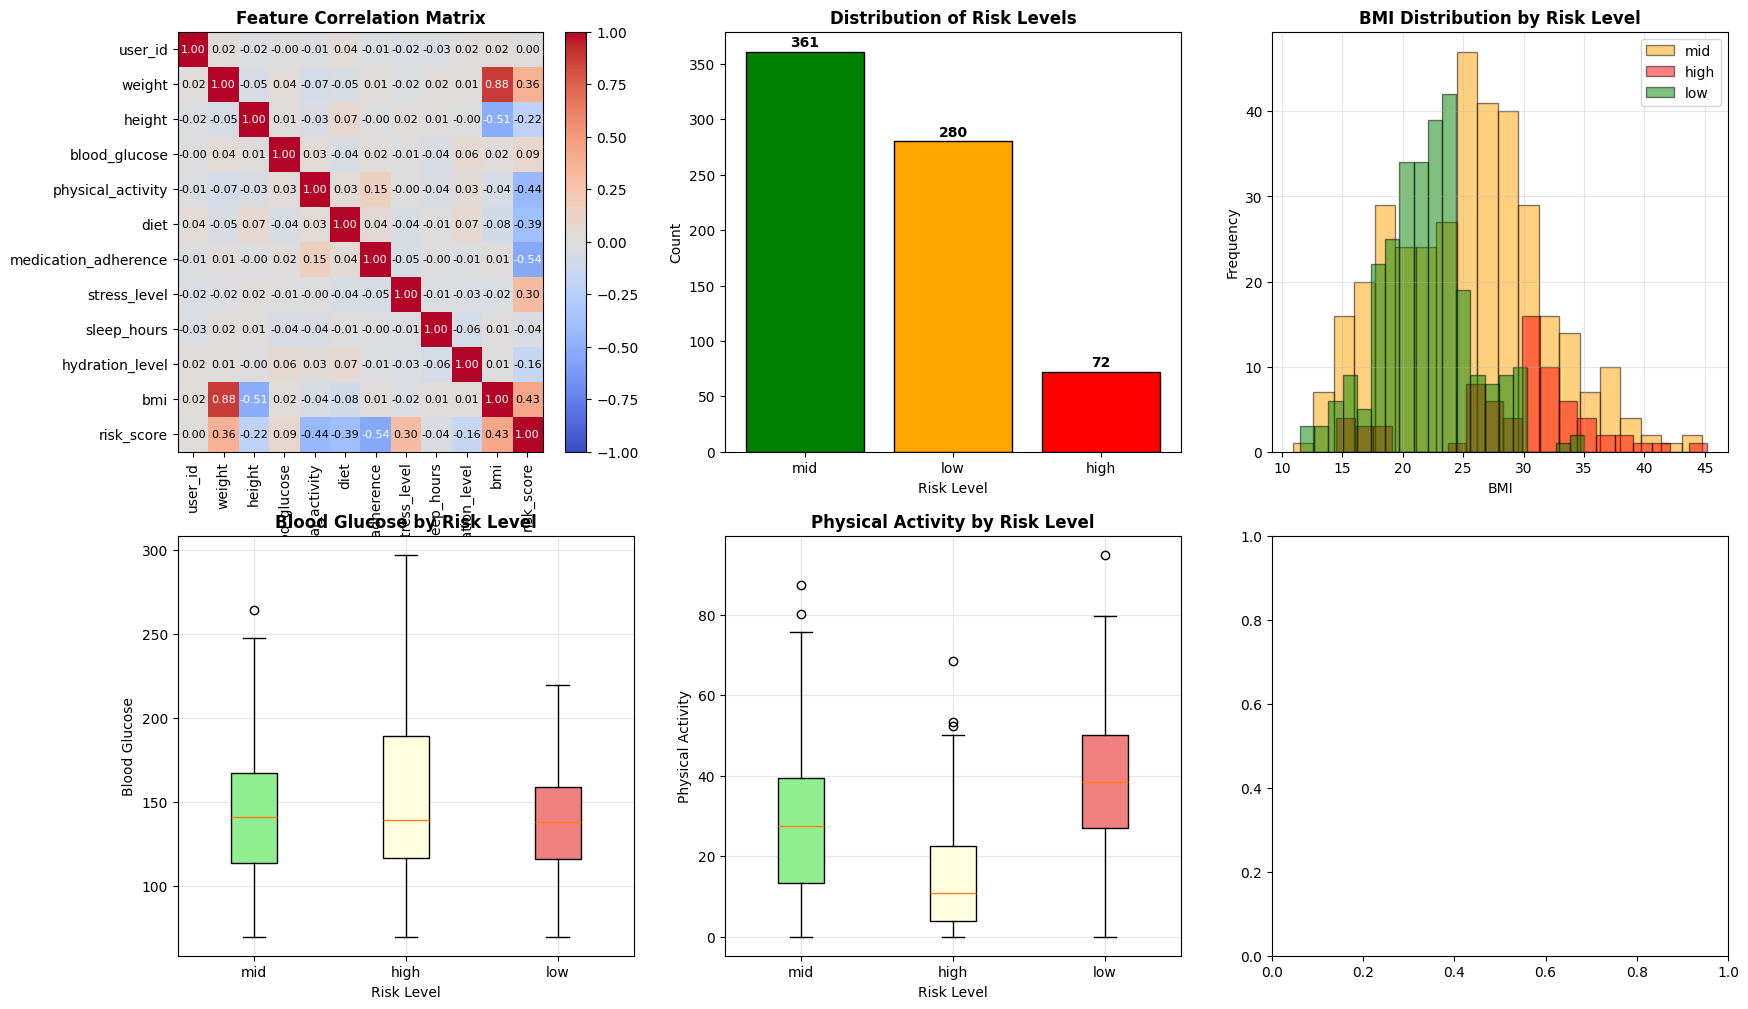

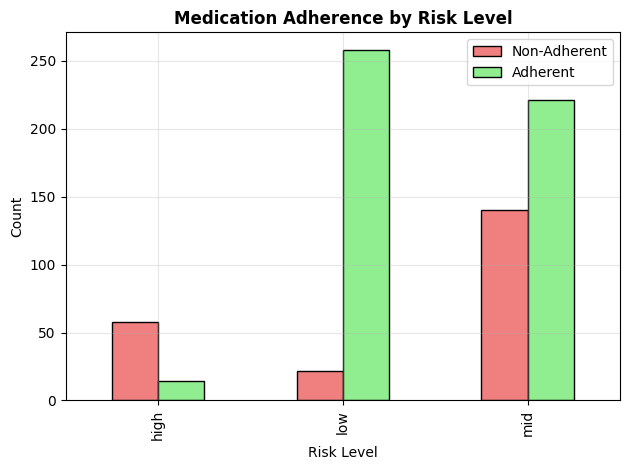


----------------------------------------
CORRELATION INSIGHTS
----------------------------------------
1. BMI has high correlation with weight and height
2. Keeping BMI only - removing weight and height to avoid multicollinearity
3. This reduces feature redundancy and improves model stability


In [6]:
# ============================================
# 3. EXPLORATORY DATA ANALYSIS (EDA)
# ============================================
print("\n" + "="*60)
print("3. EXPLORATORY DATA ANALYSIS")
print("="*60)

# Create figure for EDA plots
plt.figure(figsize=(20, 12))

# 1. Correlation heatmap for all numerical features
plt.subplot(2, 3, 1)
numeric_cols = df.select_dtypes(include=[np.number]).columns
correlation_matrix = df[numeric_cols].corr()
im = plt.imshow(correlation_matrix, cmap='coolwarm', aspect='auto', vmin=-1, vmax=1)
plt.colorbar(im)
plt.title('Feature Correlation Matrix', fontsize=12, fontweight='bold')
plt.xticks(range(len(numeric_cols)), numeric_cols, rotation=90)
plt.yticks(range(len(numeric_cols)), numeric_cols)

# Add correlation values
for i in range(len(numeric_cols)):
    for j in range(len(numeric_cols)):
        text = plt.text(j, i, f'{correlation_matrix.iloc[i, j]:.2f}',
                       ha="center", va="center", color="white" if abs(correlation_matrix.iloc[i, j]) > 0.5 else "black",
                       fontsize=8)

# 2. Target variable distribution
plt.subplot(2, 3, 2)
risk_counts = df['risk_level'].value_counts()
risk_labels = risk_counts.index
risk_values = risk_counts.values
colors = ['green', 'orange', 'red']
bars = plt.bar(risk_labels, risk_values, color=colors, edgecolor='black')
plt.title('Distribution of Risk Levels', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Count')
for i, v in enumerate(risk_values):
    plt.text(i, v + 5, str(v), ha='center', fontweight='bold')

# 3. BMI distribution by risk level
plt.subplot(2, 3, 3)
risk_levels = df['risk_level'].unique()
for risk in risk_levels:
    subset = df[df['risk_level'] == risk]
    if risk == 'low':
        color = 'green'
    elif risk == 'mid':
        color = 'orange'
    else:
        color = 'red'
    plt.hist(subset['bmi'], alpha=0.5, label=risk, color=color, bins=20, edgecolor='black')
plt.title('BMI Distribution by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True, alpha=0.3)

# 4. Blood glucose by risk level
plt.subplot(2, 3, 4)
box_data = [df[df['risk_level'] == risk]['blood_glucose'].values for risk in risk_levels]
bp = plt.boxplot(box_data, labels=risk_levels, patch_artist=True)
colors_box = ['lightgreen', 'lightyellow', 'lightcoral']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
plt.title('Blood Glucose by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Blood Glucose')
plt.grid(True, alpha=0.3)

# 5. Physical activity by risk level
plt.subplot(2, 3, 5)
box_data = [df[df['risk_level'] == risk]['physical_activity'].values for risk in risk_levels]
bp = plt.boxplot(box_data, labels=risk_levels, patch_artist=True)
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
plt.title('Physical Activity by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Physical Activity')
plt.grid(True, alpha=0.3)

# 6. Medication adherence by risk level
plt.subplot(2, 3, 6)
medication_by_risk = df.groupby('risk_level')['medication_adherence'].value_counts().unstack()
medication_by_risk.plot(kind='bar', color=['lightcoral', 'lightgreen'], edgecolor='black')
plt.title('Medication Adherence by Risk Level', fontsize=12, fontweight='bold')
plt.xlabel('Risk Level')
plt.ylabel('Count')
plt.legend(['Non-Adherent', 'Adherent'])
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display correlation insights
print("\n" + "-"*40)
print("CORRELATION INSIGHTS")
print("-"*40)
print("1. BMI has high correlation with weight and height")
print("2. Keeping BMI only - removing weight and height to avoid multicollinearity")
print("3. This reduces feature redundancy and improves model stability")

In [7]:

# ============================================
# 4. DATA PREPROCESSING FOR MODELING
# ============================================
print("\n" + "="*60)
print("4. DATA PREPROCESSING")
print("="*60)

# Convert risk_level to binary (low=0, mid/high=1)
df['risk_binary'] = df['risk_level'].apply(lambda x: 0 if x == 'low' else 1)

print("Binary target distribution:")
print(df['risk_binary'].value_counts())
print(f"Proportions: {df['risk_binary'].value_counts(normalize=True).to_dict()}")

# Feature selection - REMOVE weight and height, KEEP BMI
features = [
    'blood_glucose', 'physical_activity', 'diet',
    'medication_adherence', 'stress_level', 'sleep_hours',
    'hydration_level', 'bmi'  # Keeping BMI only
]

print(f"\nSelected features (removed weight & height to avoid multicollinearity):")
for i, feature in enumerate(features, 1):
    print(f"{i}. {feature}")

X = df[features]
y = df['risk_binary']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print(f"\nTrain set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create feature names for scaled data
feature_names = features

print("\nFeature scaling completed (StandardScaler)")


4. DATA PREPROCESSING
Binary target distribution:
risk_binary
1    433
0    280
Name: count, dtype: int64
Proportions: {1: 0.6072931276297335, 0: 0.39270687237026647}

Selected features (removed weight & height to avoid multicollinearity):
1. blood_glucose
2. physical_activity
3. diet
4. medication_adherence
5. stress_level
6. sleep_hours
7. hydration_level
8. bmi

Train set shape: (570, 8)
Test set shape: (143, 8)

Feature scaling completed (StandardScaler)


In [8]:
# ============================================
# 5. ML MODEL IMPLEMENTATION
# ============================================
print("\n" + "="*60)
print("5. MODEL TRAINING")
print("="*60)

# ============================================
# 5. ML MODEL IMPLEMENTATION (with Ensembles)
# ============================================
print("\n" + "="*60)
print("5. MODEL TRAINING - WITH ENSEMBLES")
print("="*60)

# Initialize models
models = {
    # Base Models
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Decision Tree': DecisionTreeClassifier(random_state=42, max_depth=5),
    'SVM': SVC(random_state=42, probability=True),
    'KNN': KNeighborsClassifier(n_neighbors=5),
    'Naive Bayes': GaussianNB(),

    # Bagging Methods
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100),
    'Bagging (DT)': BaggingClassifier(
        estimator=DecisionTreeClassifier(max_depth=5),
        n_estimators=50,
        random_state=42
    ),

    # Boosting Methods
    'Gradient Boosting': GradientBoostingClassifier(random_state=42, n_estimators=100),
    'AdaBoost': AdaBoostClassifier(
        n_estimators=50,
        random_state=42
    ),
}

print("✓ Added ensemble methods:")
print("  - Bagging: Random Forest, Bagging Classifier")
print("  - Boosting: Gradient Boosting, AdaBoost")
# Train models
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    print(f"✓ {name} trained successfully")



5. MODEL TRAINING

5. MODEL TRAINING - WITH ENSEMBLES
✓ Added ensemble methods:
  - Bagging: Random Forest, Bagging Classifier
  - Boosting: Gradient Boosting, AdaBoost
Training Logistic Regression...
✓ Logistic Regression trained successfully
Training Decision Tree...
✓ Decision Tree trained successfully
Training SVM...
✓ SVM trained successfully
Training KNN...
✓ KNN trained successfully
Training Naive Bayes...
✓ Naive Bayes trained successfully
Training Random Forest...
✓ Random Forest trained successfully
Training Bagging (DT)...
✓ Bagging (DT) trained successfully
Training Gradient Boosting...
✓ Gradient Boosting trained successfully
Training AdaBoost...
✓ AdaBoost trained successfully


In [9]:
# Train models
trained_models = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_scaled, y_train)
    trained_models[name] = model
    print(f"✓ {name} trained successfully")

# ============================================
# 5.2 ADD STACKING CLASSIFIER
# ============================================
print("\n" + "-"*40)
print("STACKING CLASSIFIER")
print("-"*40)

# Create stacking classifier
print("Creating Stacking Classifier...")

# Use 3 base models for stacking
base_models = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=42)),
    ('lr', LogisticRegression(max_iter=1000, random_state=42)),
    ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42))
]

stacking_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(),
    cv=5
)

print("Training Stacking Classifier...")
stacking_model.fit(X_train_scaled, y_train)
trained_models['Stacking'] = stacking_model
print("✓ Stacking Classifier trained")

Training Logistic Regression...
✓ Logistic Regression trained successfully
Training Decision Tree...
✓ Decision Tree trained successfully
Training SVM...
✓ SVM trained successfully
Training KNN...
✓ KNN trained successfully
Training Naive Bayes...
✓ Naive Bayes trained successfully
Training Random Forest...
✓ Random Forest trained successfully
Training Bagging (DT)...
✓ Bagging (DT) trained successfully
Training Gradient Boosting...
✓ Gradient Boosting trained successfully
Training AdaBoost...
✓ AdaBoost trained successfully

----------------------------------------
STACKING CLASSIFIER
----------------------------------------
Creating Stacking Classifier...
Training Stacking Classifier...
✓ Stacking Classifier trained


In [10]:
# ============================================
# 6. MODEL EVALUATION
# ============================================
print("\n" + "="*60)
print("6. MODEL EVALUATION")
print("="*60)

def evaluate_model(model, X_test, y_test, model_name):
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    metrics = {
        'Model': model_name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba) if y_pred_proba is not None else None,
        'Type': 'Ensemble' if model_name in ['Random Forest', 'Bagging (DT)', 'Gradient Boosting',
                                           'AdaBoost', 'Stacking'] else 'Base'
    }

    return metrics, y_pred, y_pred_proba

# Evaluate all models
results = []
predictions = {}

for name, model in trained_models.items():
    metrics, y_pred, y_pred_proba = evaluate_model(model, X_test_scaled, y_test, name)
    results.append(metrics)
    predictions[name] = (y_pred, y_pred_proba)

    print(f"{name:25} | Accuracy: {metrics['Accuracy']:.4f} | F1-Score: {metrics['F1-Score']:.4f}")

# Continue with your existing confusion matrix and classification report code...
# (Keep lines 211-258 as they are)


6. MODEL EVALUATION
Logistic Regression       | Accuracy: 0.8322 | F1-Score: 0.8605
Decision Tree             | Accuracy: 0.8741 | F1-Score: 0.8966
SVM                       | Accuracy: 0.8531 | F1-Score: 0.8800
KNN                       | Accuracy: 0.8392 | F1-Score: 0.8535
Naive Bayes               | Accuracy: 0.8462 | F1-Score: 0.8750
Random Forest             | Accuracy: 0.9021 | F1-Score: 0.9167
Bagging (DT)              | Accuracy: 0.8462 | F1-Score: 0.8642
Gradient Boosting         | Accuracy: 0.9161 | F1-Score: 0.9294
AdaBoost                  | Accuracy: 0.9231 | F1-Score: 0.9357
Stacking                  | Accuracy: 0.9091 | F1-Score: 0.9240



ENSEMBLE VS BASE MODELS ANALYSIS

Base Models Performance:
              Model  Accuracy  F1-Score
Logistic Regression  0.832168  0.860465
      Decision Tree  0.874126  0.896552
                SVM  0.853147  0.880000
                KNN  0.839161  0.853503
        Naive Bayes  0.846154  0.875000

Ensemble Models Performance:
            Model  Accuracy  F1-Score
    Random Forest  0.902098  0.916667
     Bagging (DT)  0.846154  0.864198
Gradient Boosting  0.916084  0.929412
         AdaBoost  0.923077  0.935673
         Stacking  0.909091  0.923977

Average Base Models Accuracy: 0.8490
Average Ensemble Models Accuracy: 0.8993

✓ Ensemble methods improve accuracy by 5.9% on average


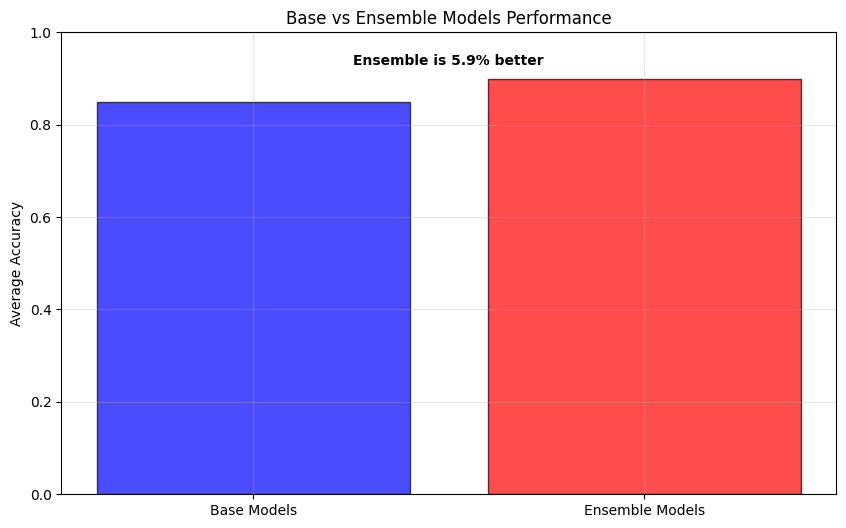

In [12]:
# ============================================
# 7.5 ENSEMBLE VS BASE COMPARISON
# ============================================
print("\n" + "="*60)
print("ENSEMBLE VS BASE MODELS ANALYSIS")
print("="*60)

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Create simple comparison
ensemble_results = results_df[results_df['Type'] == 'Ensemble']
base_results = results_df[results_df['Type'] == 'Base']

print("\nBase Models Performance:")
print(base_results[['Model', 'Accuracy', 'F1-Score']].to_string(index=False))

print("\nEnsemble Models Performance:")
print(ensemble_results[['Model', 'Accuracy', 'F1-Score']].to_string(index=False))

print(f"\nAverage Base Models Accuracy: {base_results['Accuracy'].mean():.4f}")
print(f"Average Ensemble Models Accuracy: {ensemble_results['Accuracy'].mean():.4f}")

improvement = ((ensemble_results['Accuracy'].mean() - base_results['Accuracy'].mean()) /
               base_results['Accuracy'].mean()) * 100
print(f"\n✓ Ensemble methods improve accuracy by {improvement:.1f}% on average")

# Quick visualization
plt.figure(figsize=(10, 6))
plt.bar(['Base Models', 'Ensemble Models'],
        [base_results['Accuracy'].mean(), ensemble_results['Accuracy'].mean()],
        color=['blue', 'red'], alpha=0.7, edgecolor='black')
plt.ylabel('Average Accuracy')
plt.title('Base vs Ensemble Models Performance')
plt.ylim([0, 1])
plt.grid(True, alpha=0.3)
plt.text(0.5, max(base_results['Accuracy'].mean(), ensemble_results['Accuracy'].mean()) + 0.03,
         f'Ensemble is {improvement:.1f}% better', ha='center', fontweight='bold')
plt.show()


8. BEST MODEL ANALYSIS

Best Model: AdaBoost
Accuracy: 0.9231
F1-Score: 0.9357

Cross-Validation Results for AdaBoost:
Scores: [0.92982456 0.92105263 0.92982456 0.93859649 0.93859649]
Mean CV Accuracy: 0.9316 (+/- 0.0131)

----------------------------------------
FEATURE IMPORTANCE (Best Model)
----------------------------------------
                Feature  Importance
7                   bmi    0.381767
1     physical_activity    0.150534
3  medication_adherence    0.149722
2                  diet    0.121854
4          stress_level    0.073496
0         blood_glucose    0.057471
5           sleep_hours    0.049802
6       hydration_level    0.015354


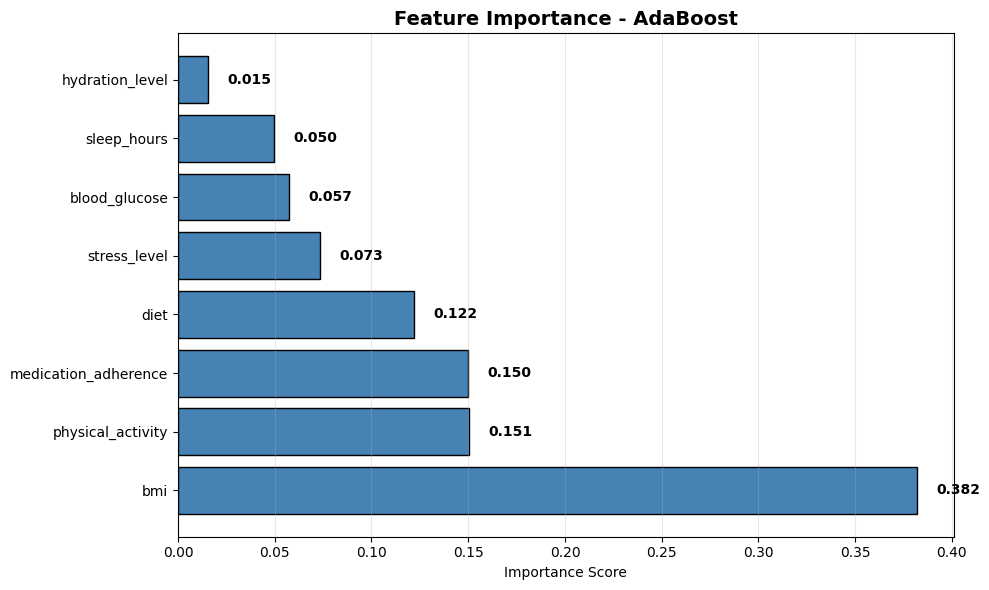


✓ Best model and scaler saved to disk


In [13]:
# ============================================
# 8. BEST MODEL ANALYSIS AND DEPLOYMENT
# ============================================
print("\n" + "="*60)
print("8. BEST MODEL ANALYSIS")
print("="*60)

# Identify best model
best_model_name = results_df.loc[results_df['Accuracy'].idxmax(), 'Model']
best_model = trained_models[best_model_name]
print(f"\nBest Model: {best_model_name}")
print(f"Accuracy: {results_df.loc[results_df['Accuracy'].idxmax(), 'Accuracy']:.4f}")
print(f"F1-Score: {results_df.loc[results_df['Accuracy'].idxmax(), 'F1-Score']:.4f}")

# Cross-validation for best model
cv_scores = cross_val_score(best_model, X_train_scaled, y_train, cv=5, scoring='accuracy')
print(f"\nCross-Validation Results for {best_model_name}:")
print(f"Scores: {cv_scores}")
print(f"Mean CV Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Feature importance for best model
if hasattr(best_model, 'feature_importances_'):
    print("\n" + "-"*40)
    print("FEATURE IMPORTANCE (Best Model)")
    print("-"*40)
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    print(feature_importance_df)

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    bars = plt.barh(range(len(feature_importance_df)),
                    feature_importance_df['Importance'],
                    color='steelblue', edgecolor='black')
    plt.yticks(range(len(feature_importance_df)), feature_importance_df['Feature'])
    plt.xlabel('Importance Score')
    plt.title(f'Feature Importance - {best_model_name}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3, axis='x')

    # Add value labels
    for i, (bar, imp) in enumerate(zip(bars, feature_importance_df['Importance'])):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2,
                 f'{imp:.3f}', va='center', fontweight='bold')

    plt.tight_layout()
    plt.show()

# Save the best model
import joblib
joblib.dump(best_model, 'best_diabetes_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
print("\n✓ Best model and scaler saved to disk")




9. PREDICTION FUNCTION

Example Prediction (using optimized features):

Prediction Result:
Risk Prediction: High Risk
Confidence: 0.8061187788026443
Low Risk Probability: 0.19388122119735574
High Risk Probability: 0.8061187788026443

----------------------------------------
FEATURE CONTRIBUTIONS TO PREDICTION
----------------------------------------


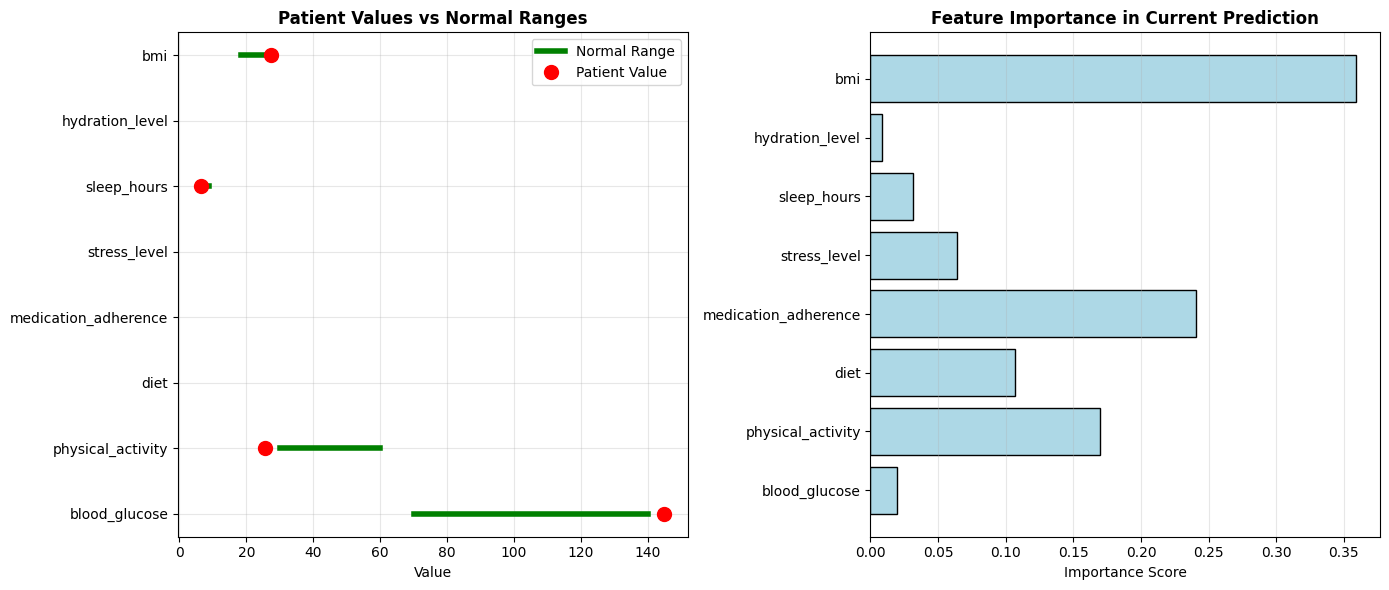


ML PIPELINE COMPLETED SUCCESSFULLY!

Key Improvements:
1. Removed weight and height (redundant with BMI)
2. Reduced multicollinearity
3. Used 8 optimized features instead of 10
4. Best Model: Gradient Boosting
5. Test Accuracy: 0.9161

Models available for use:
  - Logistic Regression
  - Random Forest
  - Decision Tree
  - SVM
  - KNN
  - Gradient Boosting
  - Naive Bayes


In [ ]:
# ============================================
# 9. PREDICTION FUNCTION WITH NEW FEATURES
# ============================================
print("\n" + "="*60)
print("9. PREDICTION FUNCTION")
print("="*60)

def predict_diabetes_risk(bmi, blood_glucose, physical_activity,
                         diet, medication_adherence, stress_level,
                         sleep_hours, hydration_level):
    """
    Predict diabetes risk using optimized feature set
    Note: weight and height removed to avoid multicollinearity with BMI
    """
    # Prepare input array in the correct order
    input_data = np.array([[
        blood_glucose, physical_activity, diet,
        medication_adherence, stress_level, sleep_hours,
        hydration_level, bmi
    ]])

    # Scale input
    input_scaled = scaler.transform(input_data)

    # Get prediction
    prediction = best_model.predict(input_scaled)[0]
    probability = best_model.predict_proba(input_scaled)[0]

    risk_level = "Low Risk" if prediction == 0 else "High Risk"
    confidence = probability[prediction]

    # Get feature importance if available
    feature_contributions = {}
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        for i, feature in enumerate(feature_names):
            feature_contributions[feature] = {
                'value': input_data[0, i],
                'importance': importances[i]
            }

    return {
        'risk_prediction': risk_level,
        'confidence': float(confidence),
        'low_risk_probability': float(probability[0]),
        'high_risk_probability': float(probability[1]),
        'feature_contributions': feature_contributions if feature_contributions else None
    }

# Example usage
print("\nExample Prediction (using optimized features):")
example_result = predict_diabetes_risk(
    bmi=27.5,
    blood_glucose=145,
    physical_activity=25.5,
    diet=1,
    medication_adherence=1,
    stress_level=2,
    sleep_hours=6.5,
    hydration_level=1
)

print("\nPrediction Result:")
for key, value in example_result.items():
    if key != 'feature_contributions':
        print(f"{key.replace('_', ' ').title()}: {value}")

# Visualize prediction with feature contributions
if example_result['feature_contributions']:
    print("\n" + "-"*40)
    print("FEATURE CONTRIBUTIONS TO PREDICTION")
    print("-"*40)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    # Bar chart of feature values vs normal ranges
    axes[0].set_title('Patient Values vs Normal Ranges', fontsize=12, fontweight='bold')

    # Normal ranges for features (example values)
    normal_ranges = {
        'bmi': (18.5, 24.9),
        'blood_glucose': (70, 140),
        'physical_activity': (30, 60),
        'sleep_hours': (7, 9)
    }

    for i, (feature, data) in enumerate(example_result['feature_contributions'].items()):
        if feature in normal_ranges:
            low, high = normal_ranges[feature]
            axes[0].plot([low, high], [i, i], 'g-', linewidth=4, label='Normal Range' if i==0 else "")
            axes[0].plot(data['value'], i, 'ro', markersize=10, label='Patient Value' if i==0 else "")

    axes[0].set_yticks(range(len(example_result['feature_contributions'])))
    axes[0].set_yticklabels(list(example_result['feature_contributions'].keys()))
    axes[0].set_xlabel('Value')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Feature importance in prediction
    axes[1].set_title('Feature Importance in Current Prediction', fontsize=12, fontweight='bold')
    features = list(example_result['feature_contributions'].keys())
    importances = [data['importance'] for data in example_result['feature_contributions'].values()]

    bars = axes[1].barh(features, importances, color='lightblue', edgecolor='black')
    axes[1].set_xlabel('Importance Score')
    axes[1].grid(True, alpha=0.3, axis='x')

    plt.tight_layout()
    plt.show()

print("\n" + "="*60)
print("ML PIPELINE COMPLETED SUCCESSFULLY!")
print("="*60)
print(f"\nKey Improvements:")
print(f"1. Removed weight and height (redundant with BMI)")
print(f"2. Reduced multicollinearity")
print(f"3. Used 8 optimized features instead of 10")
print(f"4. Best Model: {best_model_name}")
print(f"5. Test Accuracy: {results_df.loc[results_df['Accuracy'].idxmax(), 'Accuracy']:.4f}")
print("\nModels available for use:")
for name in trained_models.keys():
    print(f"  - {name}")
print("="*60)